In [2]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Make plots appear in notebook
%matplotlib inline

# Set up nice looking plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [6]:
# Load the data
df = pd.read_csv('diabetic_data.csv')

print("Data loaded successfully!")
print(f"Dataset shape: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


Data loaded successfully!
Dataset shape: 101,766 rows, 50 columns
Memory usage: 192.87 MB


In [8]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [10]:
#Column information
print("📋 Dataset Info:")
print("="*50)
df.info()

📋 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  

In [12]:
#Readmission distribution
print("\nReadmission counts:")
print(df['readmitted'].value_counts())
print("\nReadmission percentages:")
print(df['readmitted'].value_counts(normalize=True).round(4) * 100)


Readmission counts:
readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64

Readmission percentages:
readmitted
NO     53.91
>30    34.93
<30    11.16
Name: proportion, dtype: float64


In [14]:
print("MISSING VALUES CHECK")


missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100

missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing_Count': missing.values,
    'Percentage': missing_pct.values
})

# Show only columns with missing values
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

if len(missing_df) > 0:
    print(missing_df.to_string(index=False))
else:
    print("No missing values found!")

MISSING VALUES CHECK
       Column  Missing_Count  Percentage
max_glu_serum          96420   94.746772
    A1Cresult          84748   83.277322


In [16]:
#Check for '?' placeholder values
print("CHECKING FOR '?' PLACEHOLDER VALUES")

question_marks = {}
for col in df.columns:
    if df[col].dtype == 'object':  # Only check text columns
        count = (df[col] == '?').sum()
        if count > 0:
            pct = (count / len(df)) * 100
            question_marks[col] = {'count': count, 'percentage': pct}
if question_marks:
    for col, values in question_marks.items():
        print(f"{col}: {values['count']:,} ({values['percentage']:.2f}%)")
else:
    print("No '?' values found!")

CHECKING FOR '?' PLACEHOLDER VALUES
race: 2,273 (2.23%)
weight: 98,569 (96.86%)
payer_code: 40,256 (39.56%)
medical_specialty: 49,949 (49.08%)
diag_1: 21 (0.02%)
diag_2: 358 (0.35%)
diag_3: 1,423 (1.40%)


In [18]:

# Count readmissions
readmit_counts = df['readmitted'].value_counts()
print("\nReadmission Distribution:")
print(readmit_counts)

# Get <30 day readmissions
readmit_30 = readmit_counts['<30']
total_patients = len(df)
percentage = (readmit_30 / total_patients) * 100

print(f"1. Patients readmitted within 30 days: {readmit_30:,}")
print(f"2. Percentage of total patients: {percentage:.2f}%")


Readmission Distribution:
readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64
1. Patients readmitted within 30 days: 11,357
2. Percentage of total patients: 11.16%


In [20]:
# Calculate readmission rate by age
age_readmit = df.groupby('age')['readmitted'].apply(
    lambda x: (x == '<30').sum() / len(x) * 100
).sort_values(ascending=False)

print("\n30-Day Readmission Rate by Age Group:")
print(age_readmit.round(2))
print(f"3. Age group with HIGHEST readmission rate: {age_readmit.idxmax()} ({age_readmit.max():.2f}%)")


30-Day Readmission Rate by Age Group:
age
[20-30)     14.24
[80-90)     12.08
[70-80)     11.77
[30-40)     11.23
[60-70)     11.13
[90-100)    11.10
[40-50)     10.60
[50-60)      9.67
[10-20)      5.79
[0-10)       1.86
Name: readmitted, dtype: float64
3. Age group with HIGHEST readmission rate: [20-30) (14.24%)


In [22]:
# Calculate average time for each category
avg_time = df.groupby('readmitted')['time_in_hospital'].mean()

print("\nAverage Days in Hospital by Readmission Status:")
for category, days in avg_time.items():
    print(f"  {category}: {days:.2f} days")

# Specifically compare <30 vs NO
readmit_avg = avg_time['<30']
no_readmit_avg = avg_time['NO']

print(f"Readmitted within 30 days: {readmit_avg:.2f} days")
print(f"NOT readmitted: {no_readmit_avg:.2f} days")
print(f"Difference: {readmit_avg - no_readmit_avg:.2f} days")


Average Days in Hospital by Readmission Status:
  <30: 4.77 days
  >30: 4.50 days
  NO: 4.25 days
Readmitted within 30 days: 4.77 days
NOT readmitted: 4.25 days
Difference: 0.51 days


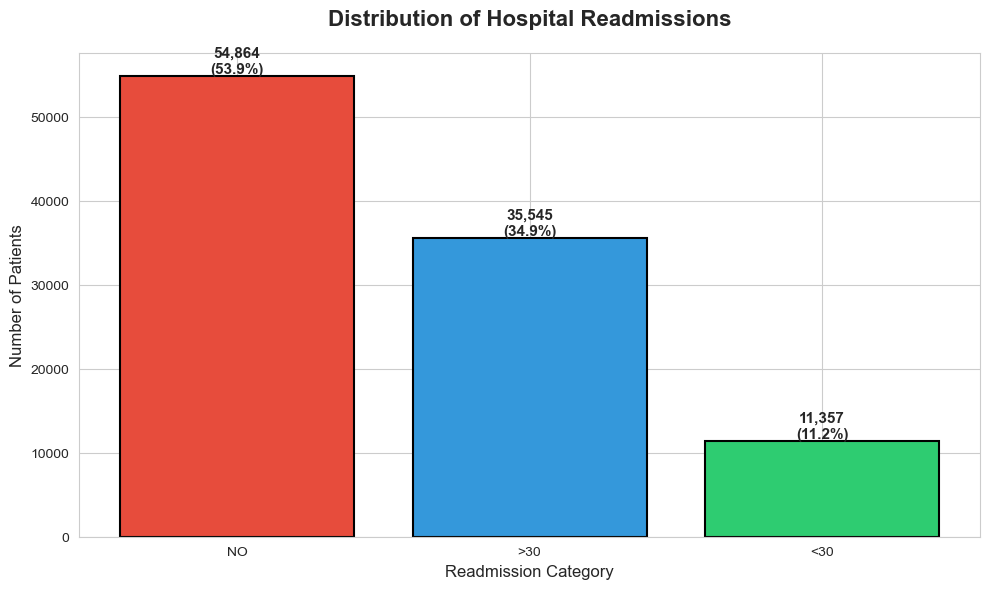

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
colors = ['#e74c3c', '#3498db', '#2ecc71']
readmit_counts = df['readmitted'].value_counts()

bars = plt.bar(readmit_counts.index, readmit_counts.values, color=colors, edgecolor='black', linewidth=1.5)
plt.title('Distribution of Hospital Readmissions', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Readmission Category', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}\n({height/len(df)*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

<Figure size 1400x600 with 0 Axes>

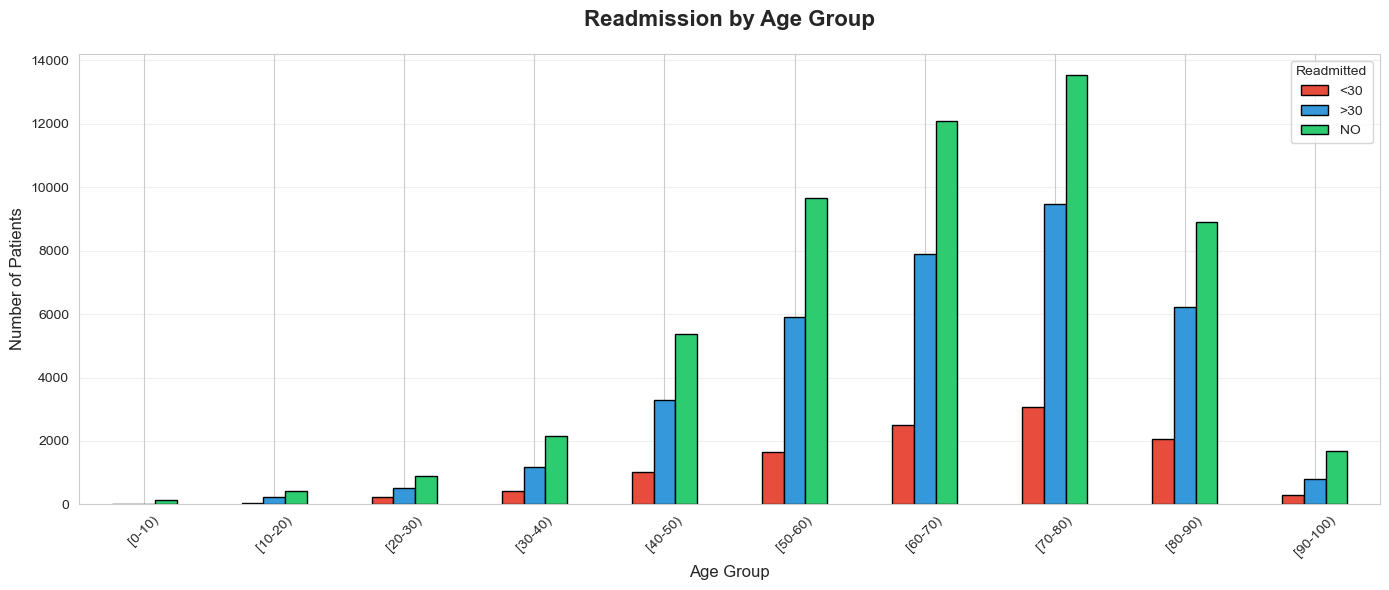

In [26]:
plt.figure(figsize=(14, 6))

# Define age order
age_order = ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', 
             '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']

# Create grouped bar chart
age_readmit_df = df.groupby(['age', 'readmitted']).size().unstack(fill_value=0)
age_readmit_df = age_readmit_df.reindex(age_order)

ax = age_readmit_df.plot(kind='bar', figsize=(14, 6), 
                          color=['#e74c3c', '#3498db', '#2ecc71'],
                          edgecolor='black', linewidth=1)
plt.title('Readmission by Age Group', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)
plt.legend(title='Readmitted', fontsize=10)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

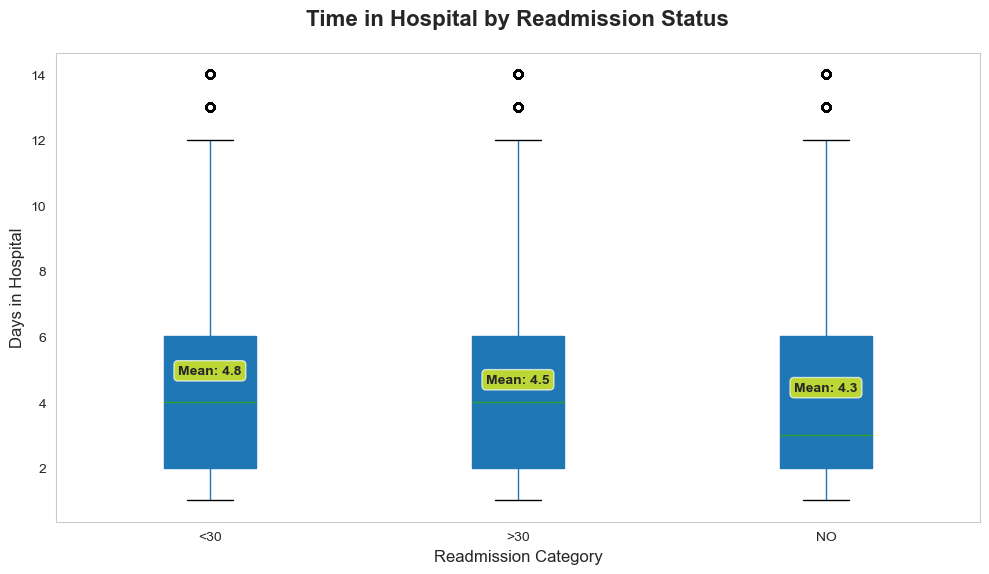

In [28]:
plt.figure(figsize=(10, 6))

# Create box plot
df.boxplot(column='time_in_hospital', by='readmitted', 
           figsize=(10, 6), patch_artist=True, grid=False)

plt.suptitle('')  # Remove default title
plt.title('Time in Hospital by Readmission Status', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Readmission Category', fontsize=12)
plt.ylabel('Days in Hospital', fontsize=12)

# Add mean values as text
for i, category in enumerate(['<30', '>30', 'NO']):
    mean_val = df[df['readmitted'] == category]['time_in_hospital'].mean()
    plt.text(i+1, mean_val, f'Mean: {mean_val:.1f}', 
             ha='center', va='bottom', fontweight='bold', 
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.show()

In [30]:
#Find all '?' values


question_mark_summary = {}

for col in df.columns:
    if df[col].dtype == 'object':  # Only check text columns
        count = (df[col] == '?').sum()
        if count > 0:
            pct = (count / len(df)) * 100
            question_mark_summary[col] = {
                'count': count, 
                'percentage': pct
            }

if question_mark_summary:
    print(f"\nFound '?' values in {len(question_mark_summary)} columns:\n")
    for col, info in sorted(question_mark_summary.items(), 
                           key=lambda x: x[1]['count'], 
                           reverse=True):
        print(f"  {col:20} : {info['count']:>6,} ({info['percentage']:>5.2f}%)")
else:
    print("No '?' values found!")


Found '?' values in 7 columns:

  weight               : 98,569 (96.86%)
  medical_specialty    : 49,949 (49.08%)
  payer_code           : 40,256 (39.56%)
  race                 :  2,273 ( 2.23%)
  diag_3               :  1,423 ( 1.40%)
  diag_2               :    358 ( 0.35%)
  diag_1               :     21 ( 0.02%)


In [44]:
#Create clean copy and replace '?'
import numpy as np

df_clean = df.copy()

# Replace '?' with NaN
df_clean = df_clean.replace('?', np.nan)

print("Created clean copy and replaced '?' with NaN")
print(f"Starting shape: {df_clean.shape}")

Created clean copy and replaced '?' with NaN
Starting shape: (101766, 50)


In [46]:
#Drop high-missing columns


# Drop weight (96.86% missing) and medical_specialty (49.08% missing)
cols_to_drop = ['weight', 'medical_specialty']

df_clean = df_clean.drop(columns=cols_to_drop)

print(f"\nDropped columns:")
for col in cols_to_drop:
    print(f"   {col}")

print(f"\n New shape: {df_clean.shape}")
print(f"   Went from 50 → {df_clean.shape[1]} columns")


Dropped columns:
   weight
   medical_specialty

 New shape: (101766, 48)
   Went from 50 → 48 columns


In [48]:
#Fill missing values

# Fill categorical columns with 'Unknown'
cols_to_fill = ['race', 'payer_code', 'diag_1', 'diag_2', 'diag_3']

for col in cols_to_fill:
    if col in df_clean.columns:
        before = df_clean[col].isnull().sum()
        df_clean[col] = df_clean[col].fillna('Unknown')
        print(f" {col:15} : Filled {before:,} missing values")

# Verify no missing values remain in these columns
print(f"\n Verification:")
for col in cols_to_fill:
    missing = df_clean[col].isnull().sum()
    print(f"  {col:15} : {missing} missing values remaining")

 race            : Filled 2,273 missing values
 payer_code      : Filled 40,256 missing values
 diag_1          : Filled 21 missing values
 diag_2          : Filled 358 missing values
 diag_3          : Filled 1,423 missing values

 Verification:
  race            : 0 missing values remaining
  payer_code      : 0 missing values remaining
  diag_1          : 0 missing values remaining
  diag_2          : 0 missing values remaining
  diag_3          : 0 missing values remaining


In [50]:
#Final missing value check

missing = df_clean.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

if len(missing) > 0:
    print("\n Columns still with missing values:")
    for col, count in missing.items():
        pct = (count / len(df_clean)) * 100
        print(f"  {col:20} : {count:>6,} ({pct:>5.2f}%)")
else:
    print("\n NO MISSING VALUES! Data is clean!")


 Columns still with missing values:
  max_glu_serum        : 96,420 (94.75%)
  A1Cresult            : 84,748 (83.28%)


In [52]:
#Handle remaining missing values (max_glu_serum and A1Cresult)


# These tests weren't performed on most patients
# Fill with 'None' to indicate test not performed
df_clean['max_glu_serum'] = df_clean['max_glu_serum'].fillna('None')
df_clean['A1Cresult'] = df_clean['A1Cresult'].fillna('None')

print("max_glu_serum: Filled missing with 'None'")
print("A1Cresult: Filled missing with 'None'")

# Final verification
missing_total = df_clean.isnull().sum().sum()
print(f"\n Total missing values remaining: {missing_total}")

if missing_total == 0:
    print("ALL MISSING VALUES HANDLED!")

max_glu_serum: Filled missing with 'None'
A1Cresult: Filled missing with 'None'

 Total missing values remaining: 0
ALL MISSING VALUES HANDLED!


In [56]:
#Create diagnosis category function
def categorize_diagnosis(diag):
    """
    Group ICD-9 diagnosis codes into major disease categories
    """
    if pd.isna(diag) or diag == 'Unknown':
        return 'Unknown'
    
    diag_str = str(diag)
    
    # Extract first 3 digits
    if diag_str.startswith('V') or diag_str.startswith('E'):
        first_three = diag_str[:3]
    else:
        # Get numeric part
        numeric_part = ''.join(filter(str.isdigit, diag_str))
        if not numeric_part:
            return 'Other'
        first_three = numeric_part[:3]
    
    try:
        code = int(first_three) if first_three.isdigit() else 0
    except:
        return 'Other'
    
    # Categorize based on ICD-9 ranges
    if code == 250:
        return 'Diabetes'
    elif 390 <= code <= 459 or code == 785:
        return 'Circulatory'
    elif 460 <= code <= 519 or code == 786:
        return 'Respiratory'
    elif 520 <= code <= 579 or code == 787:
        return 'Digestive'
    elif 580 <= code <= 629 or code == 788:
        return 'Genitourinary'
    elif 710 <= code <= 739:
        return 'Musculoskeletal'
    elif 800 <= code <= 999:
        return 'Injury'
    elif 140 <= code <= 239:
        return 'Neoplasms'
    elif 240 <= code <= 279:
        return 'Endocrine'
    elif 680 <= code <= 709:
        return 'Skin'
    elif 290 <= code <= 319:
        return 'Mental'
    elif 320 <= code <= 389:
        return 'Nervous'
    else:
        return 'Other'

print("Diagnosis categorization function created")


Diagnosis categorization function created


In [58]:
#Apply diagnosis categorization

# Apply to all three diagnosis columns
for diag_col in ['diag_1', 'diag_2', 'diag_3']:
    new_col = f'{diag_col}_category'
    df_clean[new_col] = df_clean[diag_col].apply(categorize_diagnosis)
    print(f"Created {new_col}")

print("\n Primary Diagnosis Distribution:")
print(df_clean['diag_1_category'].value_counts())

Created diag_1_category
Created diag_2_category
Created diag_3_category

 Primary Diagnosis Distribution:
diag_1_category
Circulatory        30437
Respiratory        14423
Digestive           9475
Other               9467
Diabetes            8757
Injury              6974
Genitourinary       5117
Musculoskeletal     4957
Neoplasms           3433
Endocrine           2702
Skin                2530
Mental              2262
Nervous             1211
Unknown               21
Name: count, dtype: int64


Target variable created!

Distribution:
readmitted_30
0    90409
1    11357
Name: count, dtype: int64

Percentages:
readmitted_30
0    88.84
1    11.16
Name: proportion, dtype: float64

 Target variable 'readmitted_30' created:
   0 = NOT readmitted within 30 days (88.84%)
   1 = Readmitted within 30 days (11.16%)


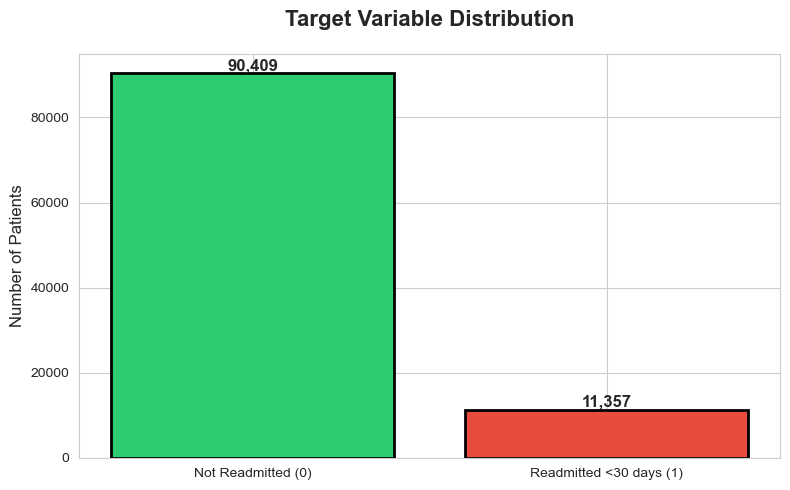

In [60]:
#Create binary target

# Before: 'NO', '>30', '<30'
# After: 0 (no readmission in 30 days), 1 (readmitted in 30 days)

df_clean['readmitted_30'] = (df_clean['readmitted'] == '<30').astype(int)

print("Target variable created!")
print("\nDistribution:")
target_counts = df_clean['readmitted_30'].value_counts()
print(target_counts)

print("\nPercentages:")
target_pct = df_clean['readmitted_30'].value_counts(normalize=True) * 100
print(target_pct.round(2))

print(f"\n Target variable 'readmitted_30' created:")
print(f"   0 = NOT readmitted within 30 days ({target_pct[0]:.2f}%)")
print(f"   1 = Readmitted within 30 days ({target_pct[1]:.2f}%)")

# Visualize
plt.figure(figsize=(8, 5))
colors = ['#2ecc71', '#e74c3c']
bars = plt.bar(['Not Readmitted (0)', 'Readmitted <30 days (1)'], 
               target_counts.values, 
               color=colors, 
               edgecolor='black', 
               linewidth=2)

plt.title('Target Variable Distribution', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Number of Patients', fontsize=12)

# Add values on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

In [62]:
#Data quality summary

print(f"\n1. Shape: {df_clean.shape[0]:,} rows × {df_clean.shape[1]} columns")

print(f"\n2. Target Variable:")
print(f"   Class 0 (No readmit): {(df_clean['readmitted_30']==0).sum():,}")
print(f"   Class 1 (Readmit):    {(df_clean['readmitted_30']==1).sum():,}")
print(f"   Imbalance Ratio:      {(df_clean['readmitted_30']==0).sum() / (df_clean['readmitted_30']==1).sum():.1f}:1")

print(f"\n3. Missing Values:")
missing_total = df_clean.isnull().sum().sum()
if missing_total == 0:
    print(f" NONE! Clean dataset!")
else:
    print(f" {missing_total:,} missing values remaining")

print(f"\n4. Data Types:")
print(df_clean.dtypes.value_counts())

print(f"\n5. Key Features Created:")
print(f"    diag_1_category")
print(f"    diag_2_category")  
print(f"    diag_3_category")
print(f"    readmitted_30 (target)")


1. Shape: 101,766 rows × 52 columns

2. Target Variable:
   Class 0 (No readmit): 90,409
   Class 1 (Readmit):    11,357
   Imbalance Ratio:      8.0:1

3. Missing Values:
 NONE! Clean dataset!

4. Data Types:
object    38
int64     14
Name: count, dtype: int64

5. Key Features Created:
    diag_1_category
    diag_2_category
    diag_3_category
    readmitted_30 (target)


In [64]:
#Save cleaned data


# Save to CSV
df_clean.to_csv('hospital_data_cleaned.csv', index=False)
print("Saved to: hospital_data_cleaned.csv")

print(f"\n Final Dataset:")
print(f"   Rows: {df_clean.shape[0]:,}")
print(f"   Columns: {df_clean.shape[1]}")
print(f"   File size: ~{df_clean.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

Saved to: hospital_data_cleaned.csv

 Final Dataset:
   Rows: 101,766
   Columns: 52
   File size: ~204.0 MB


# PHASE 3: FEATURE ENGINEERING

Creating new variables to improve model performance:
- Medication counts and changes
- Age grouping
- Service utilization metrics
- Interaction features

In [67]:
#Load cleaned data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned data
df_clean = pd.read_csv('hospital_data_cleaned.csv')

print(" Loaded cleaned data")
print(f" Shape: {df_clean.shape}")
print(f" Target variable: readmitted_30")
print(f"\nTarget distribution:")
print(df_clean['readmitted_30'].value_counts())

 Loaded cleaned data
 Shape: (101766, 52)
 Target variable: readmitted_30

Target distribution:
readmitted_30
0    90409
1    11357
Name: count, dtype: int64


Created 'total_medications' feature

Statistics:
count    101766.000000
mean          1.179706
std           0.920190
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           6.000000
Name: total_medications, dtype: float64


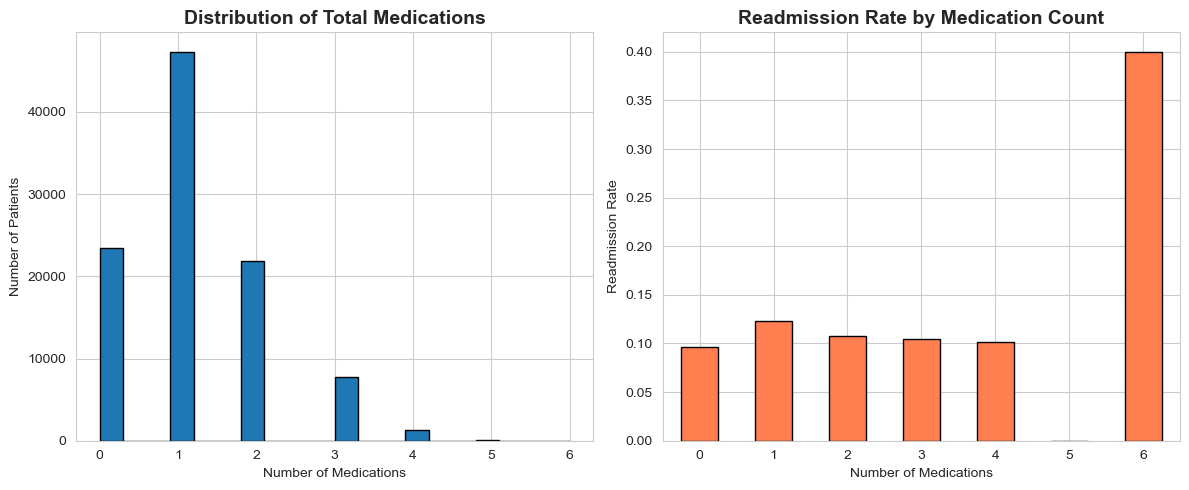


 Insight: Patients with more medications have readmission rate of:
total_medications
0    0.096
1    0.123
2    0.107
3    0.104
4    0.102
5    0.000
6    0.400
Name: readmitted_30, dtype: float64


In [69]:
#Count total medications per patient

# List of medication columns in the dataset
medication_cols = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
                   'glimepiride', 'acetohexamide', 'glipizide', 'glyburide',
                   'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
                   'miglitol', 'troglitazone', 'tolazamide', 'insulin',
                   'glyburide-metformin', 'glipizide-metformin',
                   'glimepiride-pioglitazone', 'metformin-rosiglitazone',
                   'metformin-pioglitazone']

# Count how many medications are NOT 'No' (meaning they're prescribed)
df_clean['total_medications'] = 0
for col in medication_cols:
    if col in df_clean.columns:
        df_clean['total_medications'] += (df_clean[col] != 'No').astype(int)

print(f"Created 'total_medications' feature")
print(f"\nStatistics:")
print(df_clean['total_medications'].describe())

# Visualize
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
df_clean['total_medications'].hist(bins=20, edgecolor='black')
plt.title('Distribution of Total Medications', fontsize=14, fontweight='bold')
plt.xlabel('Number of Medications')
plt.ylabel('Number of Patients')

plt.subplot(1, 2, 2)
df_clean.groupby('total_medications')['readmitted_30'].mean().plot(kind='bar', color='coral', edgecolor='black')
plt.title('Readmission Rate by Medication Count', fontsize=14, fontweight='bold')
plt.xlabel('Number of Medications')
plt.ylabel('Readmission Rate')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

print(f"\n Insight: Patients with more medications have readmission rate of:")
print(df_clean.groupby('total_medications')['readmitted_30'].mean().round(3))

 Created 'med_changed' feature

Distribution:
med_changed
0    54755
1    47011
Name: count, dtype: int64

Readmission rate:
med_changed
0    0.105908
1    0.118228
Name: readmitted_30, dtype: float64


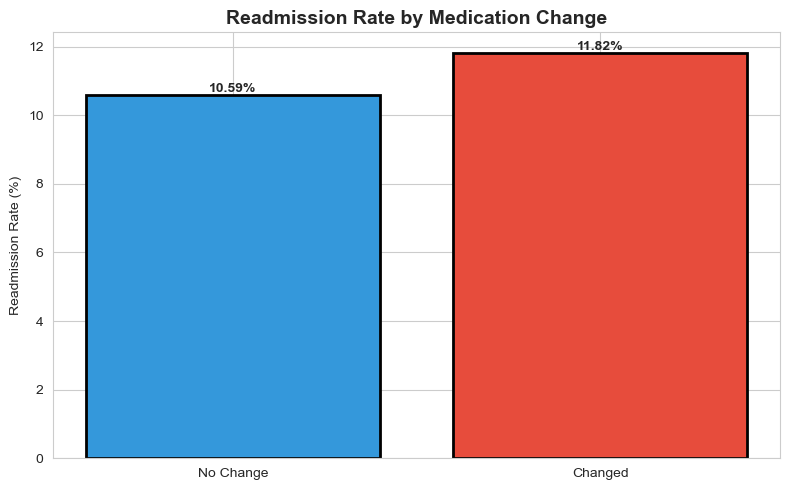

In [71]:
#Medication change flag

# Check if 'change' column exists and create binary flag
if 'change' in df_clean.columns:
    df_clean['med_changed'] = (df_clean['change'] == 'Ch').astype(int)
    print(" Created 'med_changed' feature")
    
    print("\nDistribution:")
    print(df_clean['med_changed'].value_counts())
    
    print("\nReadmission rate:")
    print(df_clean.groupby('med_changed')['readmitted_30'].mean())
    
    # Visualize
    plt.figure(figsize=(8, 5))
    readmit_by_change = df_clean.groupby('med_changed')['readmitted_30'].mean() * 100
    bars = plt.bar(['No Change', 'Changed'], readmit_by_change.values, 
                   color=['#3498db', '#e74c3c'], edgecolor='black', linewidth=2)
    plt.title('Readmission Rate by Medication Change', fontsize=14, fontweight='bold')
    plt.ylabel('Readmission Rate (%)')
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}%',
                 ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("'change' column not found")

In [73]:
#Diabetes medication flag

if 'diabetesMed' in df_clean.columns:
    df_clean['on_diabetes_med'] = (df_clean['diabetesMed'] == 'Yes').astype(int)
    print(" Created 'on_diabetes_med' feature")
    
    print("\nDistribution:")
    print(df_clean['on_diabetes_med'].value_counts())
    
    print("\nReadmission rate:")
    print(df_clean.groupby('on_diabetes_med')['readmitted_30'].mean())
else:
    print(" 'diabetesMed' column not found")

 Created 'on_diabetes_med' feature

Distribution:
on_diabetes_med
1    78363
0    23403
Name: count, dtype: int64

Readmission rate:
on_diabetes_med
0    0.095971
1    0.116267
Name: readmitted_30, dtype: float64


Created 'age_group' feature (0-9 scale)

Age distribution:
age_group
0      161
1      691
2     1657
3     3775
4     9685
5    17256
6    22483
7    26068
8    17197
9     2793
Name: count, dtype: int64

Readmission rate by age group:
age_group
0    0.019
1    0.058
2    0.142
3    0.112
4    0.106
5    0.097
6    0.111
7    0.118
8    0.121
9    0.111
Name: readmitted_30, dtype: float64


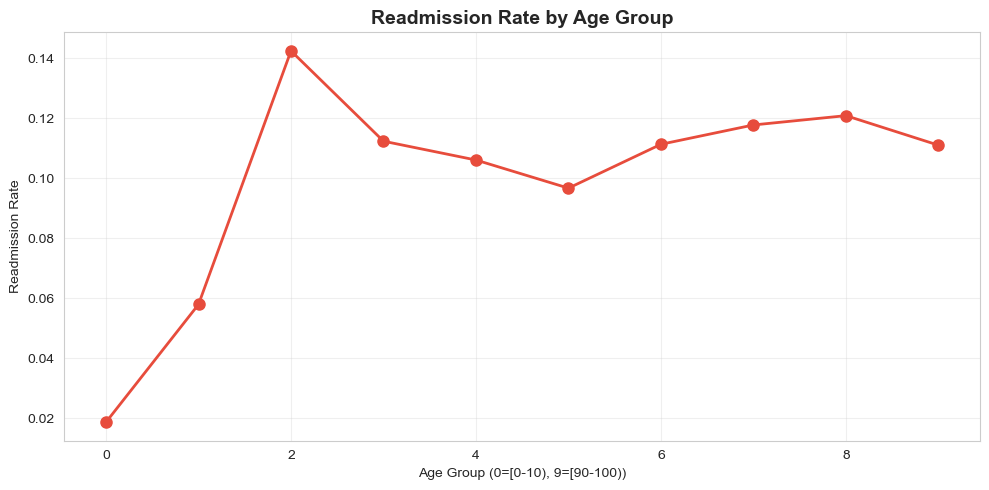

In [75]:
#Age group encoding

# Map age ranges to numeric values (ordinal encoding)
age_mapping = {
    '[0-10)': 0,
    '[10-20)': 1,
    '[20-30)': 2,
    '[30-40)': 3,
    '[40-50)': 4,
    '[50-60)': 5,
    '[60-70)': 6,
    '[70-80)': 7,
    '[80-90)': 8,
    '[90-100)': 9
}

df_clean['age_group'] = df_clean['age'].map(age_mapping)

print("Created 'age_group' feature (0-9 scale)")
print("\nAge distribution:")
print(df_clean['age_group'].value_counts().sort_index())

print("\nReadmission rate by age group:")
print(df_clean.groupby('age_group')['readmitted_30'].mean().round(3))

# Visualize
plt.figure(figsize=(10, 5))
df_clean.groupby('age_group')['readmitted_30'].mean().plot(kind='line', marker='o', linewidth=2, markersize=8, color='#e74c3c')
plt.title('Readmission Rate by Age Group', fontsize=14, fontweight='bold')
plt.xlabel('Age Group (0=[0-10), 9=[90-100))')
plt.ylabel('Readmission Rate')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

 Created 'num_diagnoses' feature

Distribution:
num_diagnoses
0         1
1       278
2      1243
3    100244
Name: count, dtype: int64

Readmission rate by number of diagnoses:
num_diagnoses
0    0.000
1    0.065
2    0.072
3    0.112
Name: readmitted_30, dtype: float64


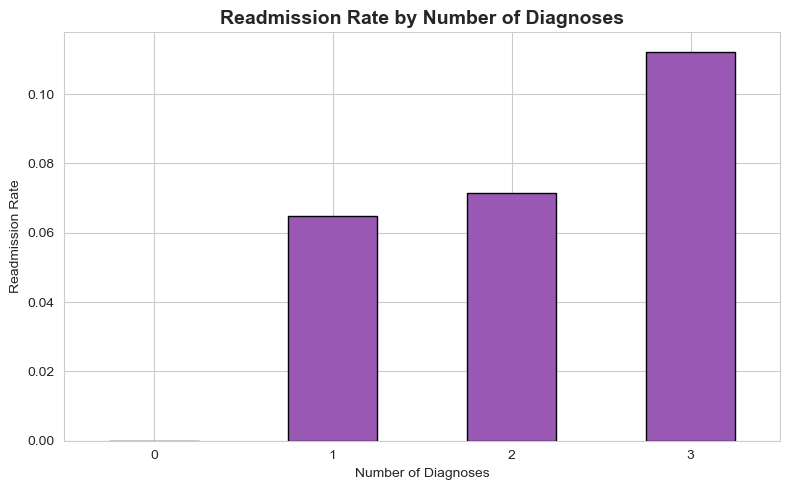

In [77]:
#Number of diagnoses

# Count non-Unknown diagnoses
df_clean['num_diagnoses'] = (
    (df_clean['diag_1_category'] != 'Unknown').astype(int) +
    (df_clean['diag_2_category'] != 'Unknown').astype(int) +
    (df_clean['diag_3_category'] != 'Unknown').astype(int)
)

print(" Created 'num_diagnoses' feature")
print("\nDistribution:")
print(df_clean['num_diagnoses'].value_counts().sort_index())

print("\nReadmission rate by number of diagnoses:")
print(df_clean.groupby('num_diagnoses')['readmitted_30'].mean().round(3))

# Visualize
plt.figure(figsize=(8, 5))
df_clean.groupby('num_diagnoses')['readmitted_30'].mean().plot(kind='bar', color='#9b59b6', edgecolor='black')
plt.title('Readmission Rate by Number of Diagnoses', fontsize=14, fontweight='bold')
plt.xlabel('Number of Diagnoses')
plt.ylabel('Readmission Rate')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [79]:
#Prior encounters features

# Binary flags for prior visits
if 'number_outpatient' in df_clean.columns:
    df_clean['had_outpatient_visit'] = (df_clean['number_outpatient'] > 0).astype(int)
    print(" Created 'had_outpatient_visit'")

if 'number_emergency' in df_clean.columns:
    df_clean['had_emergency_visit'] = (df_clean['number_emergency'] > 0).astype(int)
    print(" Created 'had_emergency_visit'")

if 'number_inpatient' in df_clean.columns:
    df_clean['had_inpatient_visit'] = (df_clean['number_inpatient'] > 0).astype(int)
    print(" Created 'had_inpatient_visit'")

# Total prior visits
df_clean['total_prior_visits'] = (
    df_clean.get('number_outpatient', 0) +
    df_clean.get('number_emergency', 0) +
    df_clean.get('number_inpatient', 0)
)
print("Created 'total_prior_visits'")

print("\nReadmission rate by prior visits:")
print("\nHad outpatient visit:")
print(df_clean.groupby('had_outpatient_visit')['readmitted_30'].mean())
print("\nHad emergency visit:")
print(df_clean.groupby('had_emergency_visit')['readmitted_30'].mean())
print("\nHad inpatient visit:")
print(df_clean.groupby('had_inpatient_visit')['readmitted_30'].mean())

 Created 'had_outpatient_visit'
 Created 'had_emergency_visit'
 Created 'had_inpatient_visit'
Created 'total_prior_visits'

Readmission rate by prior visits:

Had outpatient visit:
had_outpatient_visit
0    0.106743
1    0.136269
Name: readmitted_30, dtype: float64

Had emergency visit:
had_emergency_visit
0    0.104743
1    0.166037
Name: readmitted_30, dtype: float64

Had inpatient visit:
had_inpatient_visit
0    0.084371
1    0.165544
Name: readmitted_30, dtype: float64


In [81]:
#Service utilization score

# Normalize and combine various utilization metrics
from sklearn.preprocessing import MinMaxScaler

# Select utilization columns
util_cols = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 
             'num_medications', 'number_diagnoses']

# Check which columns exist
existing_util_cols = [col for col in util_cols if col in df_clean.columns]

if len(existing_util_cols) > 0:
    # Create a scaled utilization score (0-1)
    scaler = MinMaxScaler()
    util_scaled = scaler.fit_transform(df_clean[existing_util_cols])
    df_clean['utilization_score'] = util_scaled.mean(axis=1)
    
    print(f" Created 'utilization_score' from {len(existing_util_cols)} metrics")
    print("\nScore statistics:")
    print(df_clean['utilization_score'].describe())
    
    # Divide into utilization levels
    df_clean['utilization_level'] = pd.cut(df_clean['utilization_score'], 
                                            bins=[0, 0.33, 0.66, 1.0],
                                            labels=['Low', 'Medium', 'High'])
    
    print("\nUtilization levels:")
    print(df_clean['utilization_level'].value_counts())
    
    print("\nReadmission rate by utilization level:")
    print(df_clean.groupby('utilization_level')['readmitted_30'].mean())
else:
    print(" Utilization columns not found")

 Created 'utilization_score' from 5 metrics

Score statistics:
count    101766.000000
mean          0.284361
std           0.112852
min           0.000000
25%           0.203581
50%           0.267126
75%           0.347524
max           0.860646
Name: utilization_score, dtype: float64

Utilization levels:
utilization_level
Low       71786
Medium    29540
High        439
Name: count, dtype: int64

Readmission rate by utilization level:
utilization_level
Low       0.106525
Medium    0.123290
High      0.154897
Name: readmitted_30, dtype: float64


In [83]:
#Save feature-engineered data

# Save
df_clean.to_csv('hospital_data_features.csv', index=False)

print("Saved to: hospital_data_features.csv")
print(f"\n Enhanced Dataset:")
print(f"   Rows: {df_clean.shape[0]:,}")
print(f"   Columns: {df_clean.shape[1]} (added {df_clean.shape[1] - 52} new features)")
print(f"\n New features created:")
new_features = ['total_medications', 'med_changed', 'on_diabetes_med', 
                'age_group', 'num_diagnoses', 'had_outpatient_visit',
                'had_emergency_visit', 'had_inpatient_visit', 
                'total_prior_visits', 'utilization_score', 'utilization_level']
for feat in new_features:
    if feat in df_clean.columns:
        print(f"    {feat}")

Saved to: hospital_data_features.csv

 Enhanced Dataset:
   Rows: 101,766
   Columns: 63 (added 11 new features)

 New features created:
    total_medications
    med_changed
    on_diabetes_med
    age_group
    num_diagnoses
    had_outpatient_visit
    had_emergency_visit
    had_inpatient_visit
    total_prior_visits
    utilization_score
    utilization_level


In [85]:
#Load feature-engineered data and prepare for modeling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv('hospital_data_features.csv')

print("Loaded feature-engineered data")
print(f"Shape: {df.shape}")
print(f"Target variable: readmitted_30")

Loaded feature-engineered data
Shape: (101766, 63)
Target variable: readmitted_30


In [87]:
#Select features for modeling
# Separate features we want to use vs columns to drop

# Columns to drop (IDs, redundant, or non-predictive)
drop_cols = [
    'encounter_id', 'patient_nbr',  # IDs
    'readmitted',  # Original target (we use readmitted_30)
    'utilization_level',  # Categorical version (we keep utilization_score)
    'age',  # Original (we keep age_group)
    'diag_1', 'diag_2', 'diag_3',  # Original codes (we keep categories)
]

# Drop columns that exist
drop_cols = [col for col in drop_cols if col in df.columns]
df_model = df.drop(columns=drop_cols)

print(f"Dropped {len(drop_cols)} columns")
print(f"Modeling dataset shape: {df_model.shape}")

# Separate features and target
X = df_model.drop('readmitted_30', axis=1)
y = df_model['readmitted_30']

print(f"\nFeatures (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")

Dropped 8 columns
Modeling dataset shape: (101766, 55)

Features (X): (101766, 54)
Target (y): (101766,)
Target distribution: {0: 90409, 1: 11357}


In [89]:
#Encode categorical variables
from sklearn.preprocessing import LabelEncoder

# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print(f"Found {len(categorical_cols)} categorical columns to encode:")
print(categorical_cols[:10])  # Show first 10

# Label encode each categorical column
label_encoders = {}
X_encoded = X.copy()

for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
    label_encoders[col] = le

print(f"\nEncoded all categorical variables")
print(f"Final feature shape: {X_encoded.shape}")
print(f"All features are now numeric: {X_encoded.select_dtypes(include=['object']).shape[1] == 0}")

Found 33 categorical columns to encode:
['race', 'gender', 'payer_code', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride']

Encoded all categorical variables
Final feature shape: (101766, 54)
All features are now numeric: True


In [91]:
#Train-test split
from sklearn.model_selection import train_test_split

# Split: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Maintain class balance
)

print("Train-test split complete")
print(f"\nTraining set:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  Class distribution: {y_train.value_counts().to_dict()}")

print(f"\nTest set:")
print(f"  X_test: {X_test.shape}")
print(f"  y_test: {y_test.shape}")
print(f"  Class distribution: {y_test.value_counts().to_dict()}")

Train-test split complete

Training set:
  X_train: (81412, 54)
  y_train: (81412,)
  Class distribution: {0: 72326, 1: 9086}

Test set:
  X_test: (20354, 54)
  y_test: (20354,)
  Class distribution: {0: 18083, 1: 2271}


In [93]:
#Apply SMOTE to balance classes
from imblearn.over_sampling import SMOTE

print("Original class distribution:")
print(f"Class 0: {(y_train == 0).sum()}")
print(f"Class 1: {(y_train == 1).sum()}")
print(f"Imbalance ratio: {(y_train == 0).sum() / (y_train == 1).sum():.1f}:1")

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"\nAfter SMOTE:")
print(f"Class 0: {(y_train_balanced == 0).sum()}")
print(f"Class 1: {(y_train_balanced == 1).sum()}")
print(f"Balanced: {(y_train_balanced == 0).sum() == (y_train_balanced == 1).sum()}")

print(f"\nNew training set size: {X_train_balanced.shape}")

Original class distribution:
Class 0: 72326
Class 1: 9086
Imbalance ratio: 8.0:1

After SMOTE:
Class 0: 72326
Class 1: 72326
Balanced: True

New training set size: (144652, 54)


In [95]:
#Scale features
from sklearn.preprocessing import StandardScaler

# Fit scaler on training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling complete")
print(f"Training data scaled: {X_train_scaled.shape}")
print(f"Test data scaled: {X_test_scaled.shape}")
print("\nSample of scaled features (first 5 rows, first 5 columns):")
print(X_train_scaled[:5, :5])

Feature scaling complete
Training data scaled: (144652, 54)
Test data scaled: (20354, 54)

Sample of scaled features (first 5 rows, first 5 columns):
[[-1.784817   -0.74938442 -0.65773569  3.39909222 -0.19721543]
 [ 1.4515561   1.33418831 -0.65773569 -0.52004195  0.30626326]
 [ 0.37276506  1.33418831  0.06899445 -0.52004195 -1.2041728 ]
 [-1.784817   -0.74938442 -0.65773569 -0.52004195  0.30626326]
 [-1.784817   -0.74938442 -0.65773569 -0.16375703 -0.19721543]]


In [97]:
#Train Logistic Regression baseline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import time

print("Training Logistic Regression...")
start_time = time.time()

# Train model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train_balanced)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

training_time = time.time() - start_time

print(f"Training completed in {training_time:.2f} seconds")
print("\nLogistic Regression Results:")
print(classification_report(y_test, y_pred_lr, target_names=['Not Readmitted', 'Readmitted']))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba_lr):.4f}")

Training Logistic Regression...
Training completed in 1.36 seconds

Logistic Regression Results:
                precision    recall  f1-score   support

Not Readmitted       0.89      1.00      0.94     18083
    Readmitted       0.42      0.01      0.02      2271

      accuracy                           0.89     20354
     macro avg       0.66      0.50      0.48     20354
  weighted avg       0.84      0.89      0.84     20354

ROC-AUC Score: 0.6172


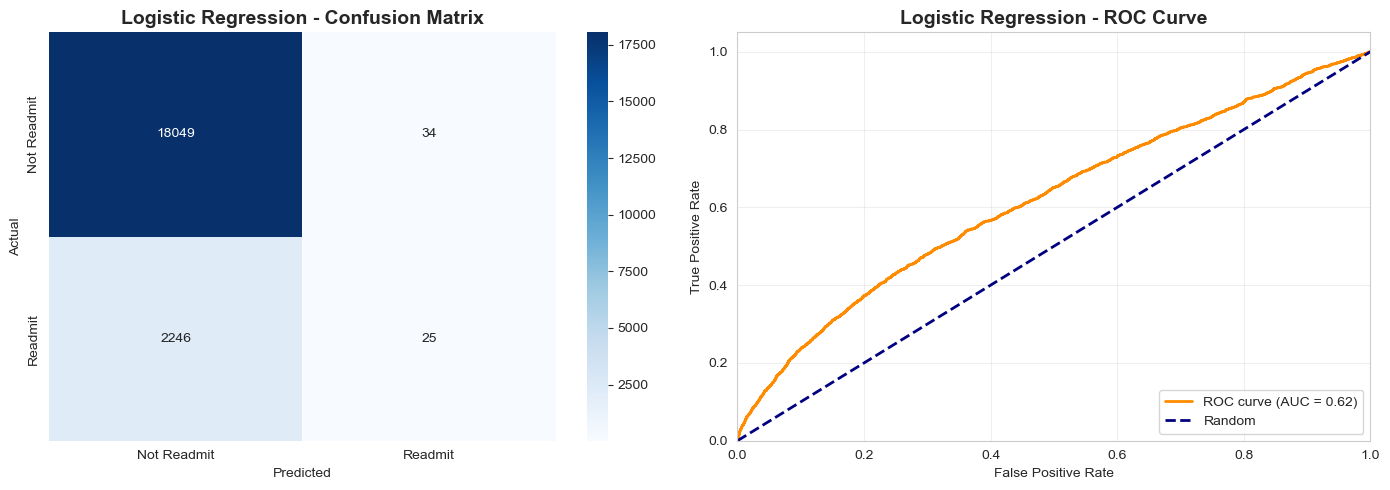

In [99]:
#Visualize LR performance
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lr)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=['Not Readmit', 'Readmit'],
            yticklabels=['Not Readmit', 'Readmit'])
axes[0].set_title('Logistic Regression - Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# Plot 2: ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba_lr)
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Logistic Regression - ROC Curve', fontsize=14, fontweight='bold')
axes[1].legend(loc="lower right")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [101]:
#Train Random Forest
from sklearn.ensemble import RandomForestClassifier

print("Training Random Forest...")
start_time = time.time()

# Train model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train_balanced)

# Predictions
y_pred_rf = rf_model.predict(X_test_scaled)
y_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

training_time = time.time() - start_time

print(f"Training completed in {training_time:.2f} seconds")
print("\nRandom Forest Results:")
print(classification_report(y_test, y_pred_rf, target_names=['Not Readmitted', 'Readmitted']))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba_rf):.4f}")

Training Random Forest...
Training completed in 1.83 seconds

Random Forest Results:
                precision    recall  f1-score   support

Not Readmitted       0.89      0.87      0.88     18083
    Readmitted       0.14      0.17      0.16      2271

      accuracy                           0.80     20354
     macro avg       0.52      0.52      0.52     20354
  weighted avg       0.81      0.80      0.80     20354

ROC-AUC Score: 0.5603


In [106]:
#Train XGBoost
from xgboost import XGBClassifier

print("Training XGBoost...")
start_time = time.time()

# Train model
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(X_train_scaled, y_train_balanced)

# Predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

training_time = time.time() - start_time

print(f"Training completed in {training_time:.2f} seconds")
print("\nXGBoost Results:")
print(classification_report(y_test, y_pred_xgb, target_names=['Not Readmitted', 'Readmitted']))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba_xgb):.4f}")

Training XGBoost...
Training completed in 0.53 seconds

XGBoost Results:
                precision    recall  f1-score   support

Not Readmitted       0.89      0.92      0.91     18083
    Readmitted       0.18      0.13      0.15      2271

      accuracy                           0.84     20354
     macro avg       0.54      0.53      0.53     20354
  weighted avg       0.81      0.84      0.82     20354

ROC-AUC Score: 0.5858


In [108]:
#Compare model performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

models = {
    'Logistic Regression': (y_pred_lr, y_proba_lr),
    'Random Forest': (y_pred_rf, y_proba_rf),
    'XGBoost': (y_pred_xgb, y_proba_xgb)
}

results = []

for model_name, (y_pred, y_proba) in models.items():
    results.append({
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    })

results_df = pd.DataFrame(results)
print("Model Performance Comparison:")
print(results_df.to_string(index=False))

# Find best model
best_model = results_df.loc[results_df['F1-Score'].idxmax(), 'Model']
print(f"\nBest Model (by F1-Score): {best_model}")

Model Performance Comparison:
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression  0.887983   0.423729 0.011008  0.021459 0.617214
      Random Forest  0.795372   0.144786 0.169969  0.156370 0.560294
            XGBoost  0.835757   0.177885 0.130339  0.150445 0.585753

Best Model (by F1-Score): Random Forest


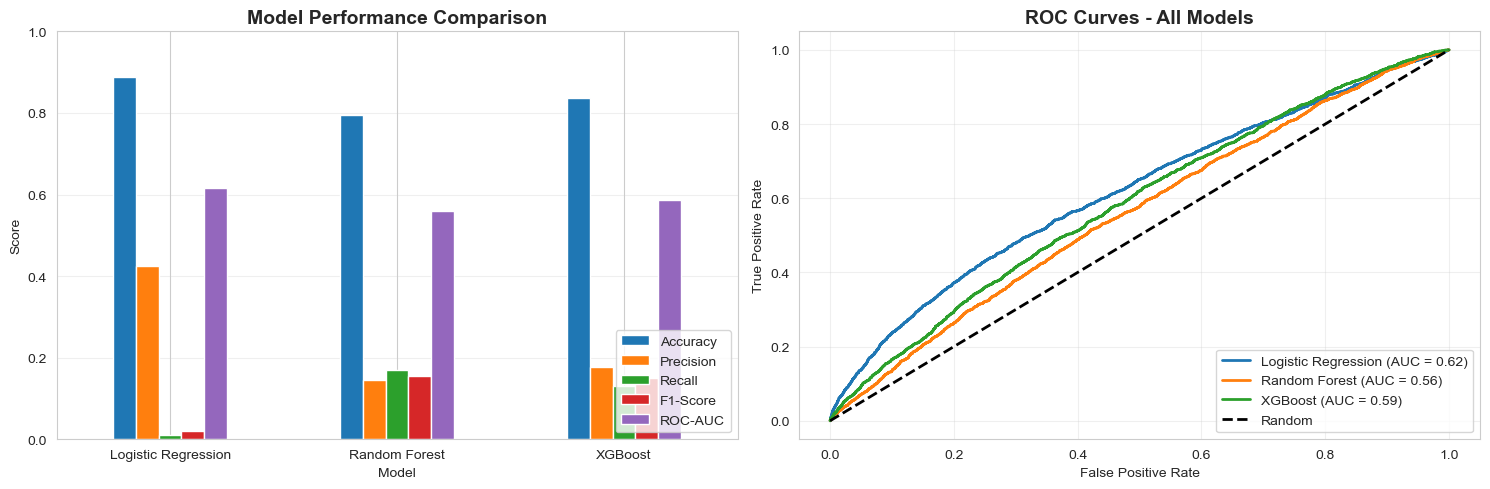

In [110]:
#Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Metrics comparison
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
results_df.set_index('Model')[metrics_to_plot].plot(kind='bar', ax=axes[0], rot=0)
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Score')
axes[0].legend(loc='lower right')
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: ROC curves comparison
for model_name, (y_pred, y_proba) in models.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

axes[1].plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves - All Models', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

Top 15 Most Important Features:
             Feature  Importance
         med_changed    0.185567
           metformin    0.066015
              gender    0.065458
              change    0.056152
 had_emergency_visit    0.050380
                race    0.044754
       rosiglitazone    0.043388
 had_inpatient_visit    0.042426
had_outpatient_visit    0.034188
         glimepiride    0.033188
           glyburide    0.032405
         diabetesMed    0.031379
           glipizide    0.028404
        pioglitazone    0.027813
   number_outpatient    0.027365


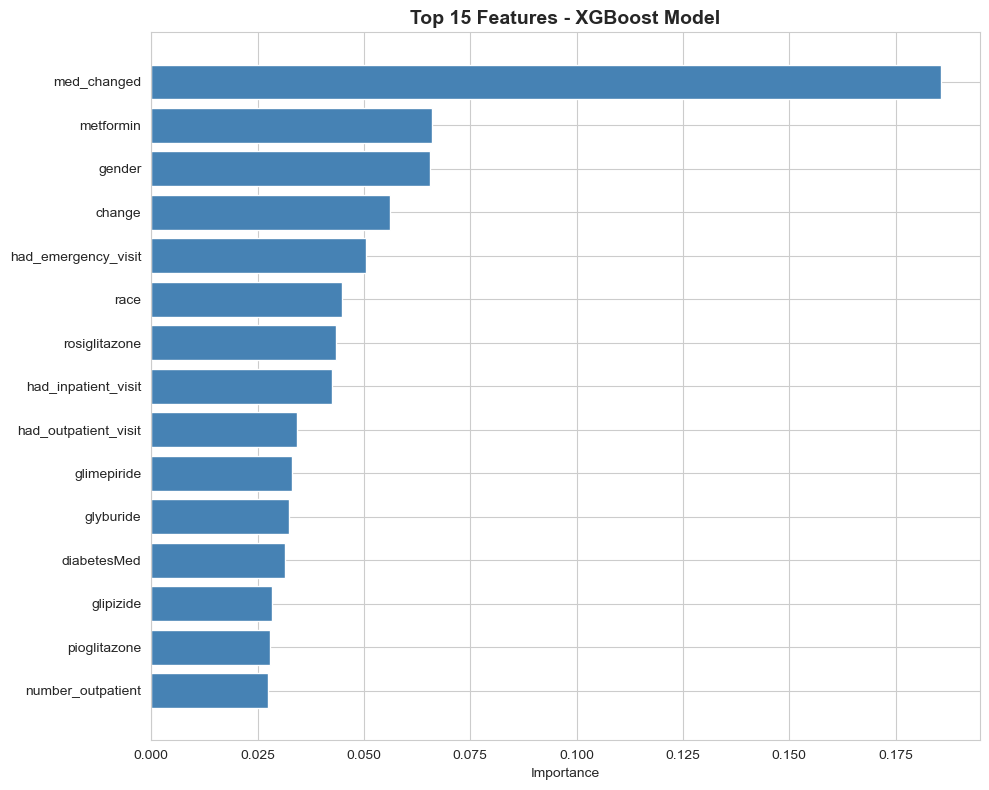

In [112]:
#Feature importance analysis
feature_importance = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 15 Most Important Features:")
print(feature_importance.head(15).to_string(index=False))

# Visualize
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance')
plt.title('Top 15 Features - XGBoost Model', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [114]:
#Save models
import pickle

# Save best model (XGBoost)
with open('readmission_model_xgboost.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

# Save scaler
with open('feature_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save results
results_df.to_csv('model_comparison_results.csv', index=False)
feature_importance.to_csv('feature_importance.csv', index=False)

print("Saved files:")
print("  - readmission_model_xgboost.pkl")
print("  - feature_scaler.pkl")
print("  - model_comparison_results.csv")
print("  - feature_importance.csv")

Saved files:
  - readmission_model_xgboost.pkl
  - feature_scaler.pkl
  - model_comparison_results.csv
  - feature_importance.csv


In [116]:
#Retrain models with class weights (no SMOTE)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
import time

print("Retraining models with class weights instead of SMOTE...")
print("=" * 60)

# Calculate class weights
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Class imbalance ratio: {scale_pos_weight:.1f}:1")

# Use original unbalanced training data with scaling
X_train_scaled_orig = scaler.fit_transform(X_train)
X_test_scaled_orig = scaler.transform(X_test)

# Model 1: Logistic Regression with class weights
print("\n1. Training Logistic Regression with class weights...")
lr_model_v2 = LogisticRegression(
    max_iter=1000, 
    class_weight='balanced',
    random_state=42
)
lr_model_v2.fit(X_train_scaled_orig, y_train)
y_pred_lr_v2 = lr_model_v2.predict(X_test_scaled_orig)
y_proba_lr_v2 = lr_model_v2.predict_proba(X_test_scaled_orig)[:, 1]

print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr_v2))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_lr_v2):.4f}")

# Model 2: Random Forest with class weights
print("\n2. Training Random Forest with class weights...")
rf_model_v2 = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_model_v2.fit(X_train_scaled_orig, y_train)
y_pred_rf_v2 = rf_model_v2.predict(X_test_scaled_orig)
y_proba_rf_v2 = rf_model_v2.predict_proba(X_test_scaled_orig)[:, 1]

print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf_v2))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_rf_v2):.4f}")

# Model 3: XGBoost with scale_pos_weight
print("\n3. Training XGBoost with scale_pos_weight...")
xgb_model_v2 = XGBClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.05,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss'
)
xgb_model_v2.fit(X_train_scaled_orig, y_train)
y_pred_xgb_v2 = xgb_model_v2.predict(X_test_scaled_orig)
y_proba_xgb_v2 = xgb_model_v2.predict_proba(X_test_scaled_orig)[:, 1]

print("XGBoost Results:")
print(classification_report(y_test, y_pred_xgb_v2))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_xgb_v2):.4f}")

Retraining models with class weights instead of SMOTE...
Class imbalance ratio: 8.0:1

1. Training Logistic Regression with class weights...
Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.92      0.66      0.77     18083
           1       0.17      0.54      0.26      2271

    accuracy                           0.65     20354
   macro avg       0.54      0.60      0.51     20354
weighted avg       0.84      0.65      0.71     20354

ROC-AUC: 0.6470

2. Training Random Forest with class weights...
Random Forest Results:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89     18083
           1       0.22      0.30      0.25      2271

    accuracy                           0.80     20354
   macro avg       0.56      0.58      0.57     20354
weighted avg       0.83      0.80      0.82     20354

ROC-AUC: 0.6674

3. Training XGBoost with scale_pos_weight...
XGBoost Results:
         

In [118]:
#Compare improved models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

models_v2 = {
    'Logistic Regression': (y_pred_lr_v2, y_proba_lr_v2),
    'Random Forest': (y_pred_rf_v2, y_proba_rf_v2),
    'XGBoost': (y_pred_xgb_v2, y_proba_xgb_v2)
}

results_v2 = []

for model_name, (y_pred, y_proba) in models_v2.items():
    results_v2.append({
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    })

results_df_v2 = pd.DataFrame(results_v2)
print("\nImproved Model Performance:")
print(results_df_v2.to_string(index=False))

best_model_v2 = results_df_v2.loc[results_df_v2['F1-Score'].idxmax(), 'Model']
print(f"\nBest Model: {best_model_v2}")


Improved Model Performance:
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression  0.648718   0.167235 0.539850  0.255363 0.647033
      Random Forest  0.802987   0.220328 0.301629  0.254647 0.667435
            XGBoost  0.703154   0.195150 0.531484  0.285478 0.676480

Best Model: XGBoost


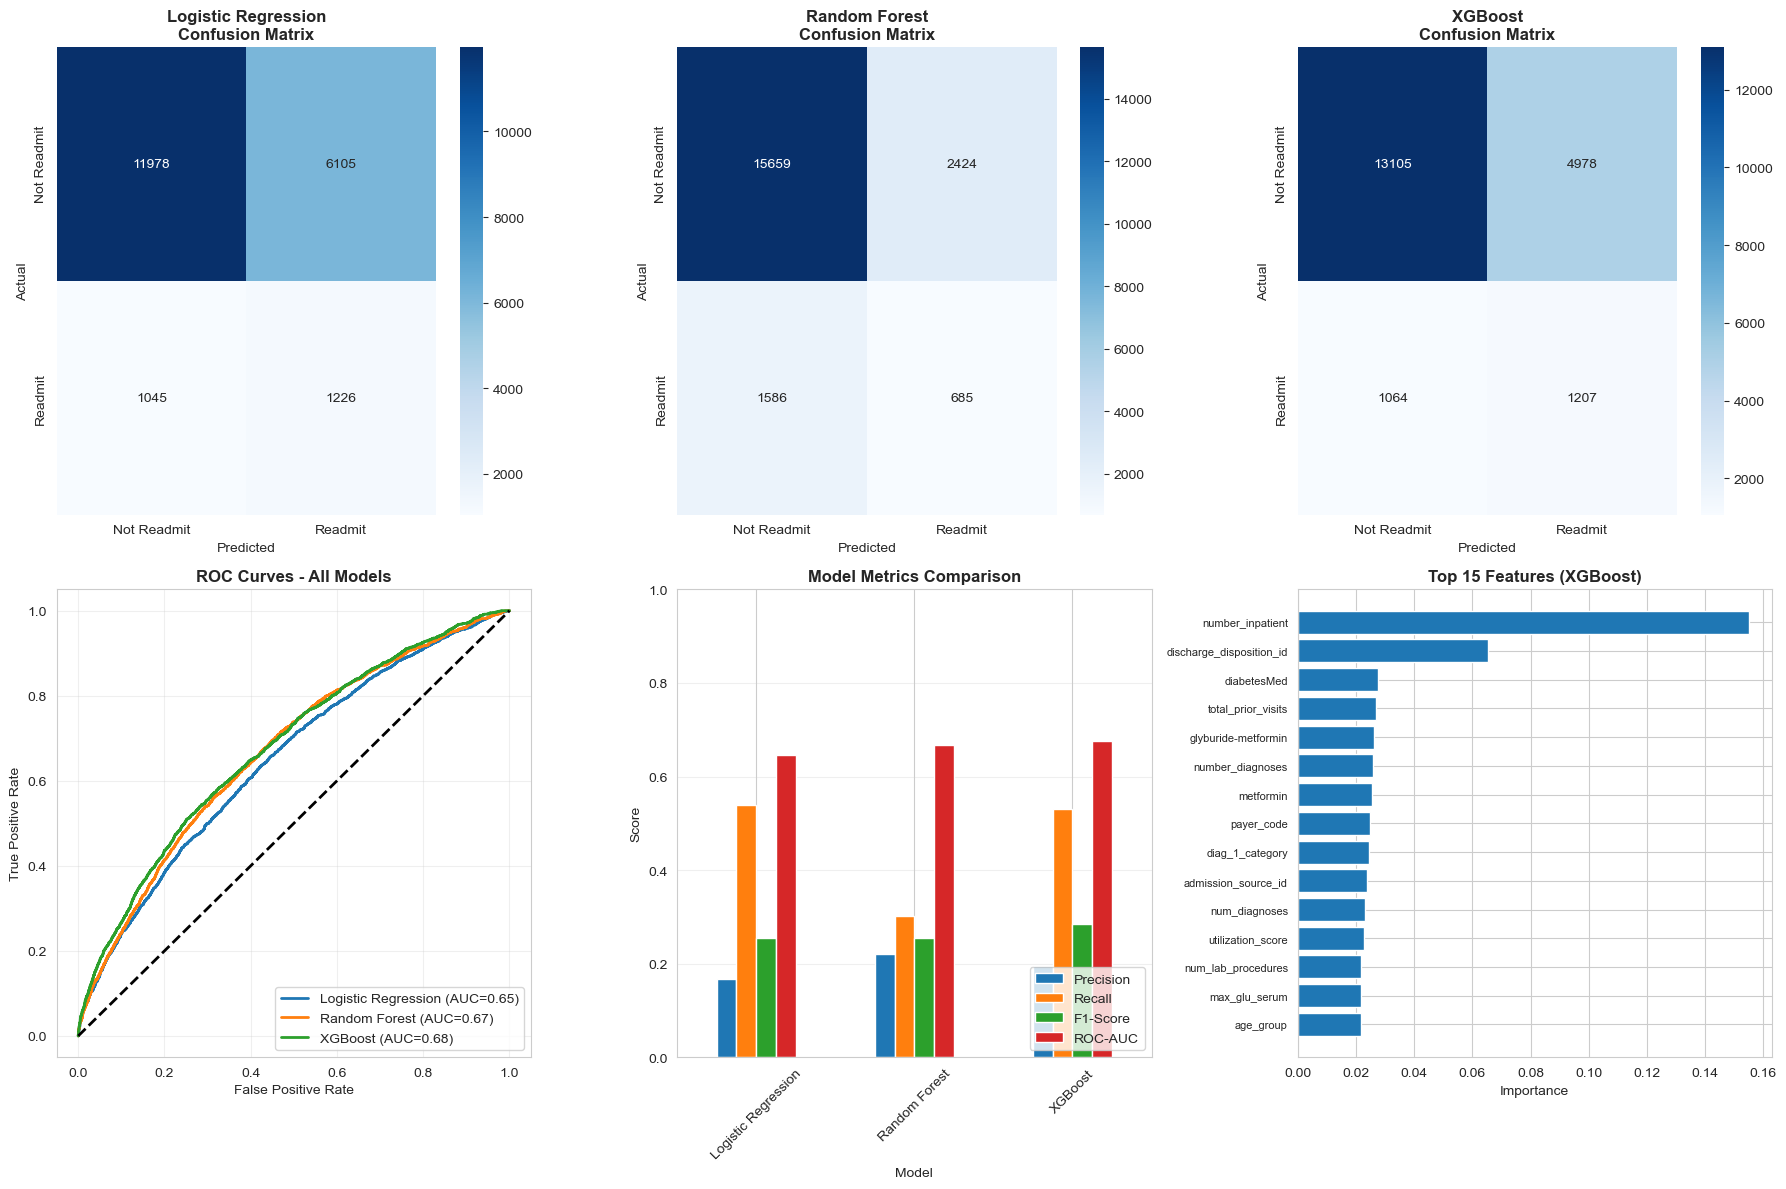

In [120]:
#Visualize improved results
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Confusion matrices for each model
models_list = [
    ('Logistic Regression', y_pred_lr_v2),
    ('Random Forest', y_pred_rf_v2),
    ('XGBoost', y_pred_xgb_v2)
]

for idx, (name, y_pred) in enumerate(models_list):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, idx],
                xticklabels=['Not Readmit', 'Readmit'],
                yticklabels=['Not Readmit', 'Readmit'])
    axes[0, idx].set_title(f'{name}\nConfusion Matrix', fontweight='bold')
    axes[0, idx].set_ylabel('Actual')
    axes[0, idx].set_xlabel('Predicted')

# ROC curves
for model_name, (y_pred, y_proba) in models_v2.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    axes[1, 0].plot(fpr, tpr, lw=2, label=f'{model_name} (AUC={roc_auc:.2f})')

axes[1, 0].plot([0, 1], [0, 1], 'k--', lw=2)
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].set_title('ROC Curves - All Models', fontweight='bold')
axes[1, 0].legend(loc='lower right')
axes[1, 0].grid(alpha=0.3)

# Model comparison bar chart
metrics_to_plot = ['Precision', 'Recall', 'F1-Score', 'ROC-AUC']
results_df_v2.set_index('Model')[metrics_to_plot].plot(kind='bar', ax=axes[1, 1], rot=45)
axes[1, 1].set_title('Model Metrics Comparison', fontweight='bold')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_ylim([0, 1])
axes[1, 1].grid(axis='y', alpha=0.3)
axes[1, 1].legend(loc='lower right')

# Feature importance (XGBoost)
feature_importance_v2 = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': xgb_model_v2.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

axes[1, 2].barh(range(len(feature_importance_v2)), feature_importance_v2['Importance'])
axes[1, 2].set_yticks(range(len(feature_importance_v2)))
axes[1, 2].set_yticklabels(feature_importance_v2['Feature'], fontsize=8)
axes[1, 2].set_xlabel('Importance')
axes[1, 2].set_title('Top 15 Features (XGBoost)', fontweight='bold')
axes[1, 2].invert_yaxis()

plt.tight_layout()
plt.show()

In [122]:
#Save improved models
import pickle

# Determine which model to save (highest F1-Score)
best_idx = results_df_v2['F1-Score'].idxmax()
best_model_name = results_df_v2.loc[best_idx, 'Model']

if best_model_name == 'Logistic Regression':
    best_model_obj = lr_model_v2
elif best_model_name == 'Random Forest':
    best_model_obj = rf_model_v2
else:
    best_model_obj = xgb_model_v2

# Save best model
with open('best_readmission_model.pkl', 'wb') as f:
    pickle.dump(best_model_obj, f)

# Save scaler
with open('feature_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save results
results_df_v2.to_csv('final_model_results.csv', index=False)

print(f"Saved best model: {best_model_name}")
print("Files saved:")
print("  - best_readmission_model.pkl")
print("  - feature_scaler.pkl")
print("  - final_model_results.csv")

Saved best model: XGBoost
Files saved:
  - best_readmission_model.pkl
  - feature_scaler.pkl
  - final_model_results.csv


In [124]:
#Optimize prediction threshold for better recall
import numpy as np
from sklearn.metrics import precision_recall_curve

# Calculate precision-recall curve for XGBoost
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_xgb_v2)

# Find threshold that gives us 70% recall
target_recall = 0.70
idx = np.argmin(np.abs(recall - target_recall))
optimal_threshold = thresholds[idx]

print(f"\nCurrent threshold (default 0.5):")
print(f"  Recall: {recall_score(y_test, y_pred_xgb_v2):.3f}")
print(f"  Precision: {precision_score(y_test, y_pred_xgb_v2):.3f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_xgb_v2):.3f}")

# Apply new threshold
y_pred_xgb_tuned = (y_proba_xgb_v2 >= optimal_threshold).astype(int)

print(f"\nOptimized threshold ({optimal_threshold:.3f}):")
print(f"  Recall: {recall_score(y_test, y_pred_xgb_tuned):.3f}")
print(f"  Precision: {precision_score(y_test, y_pred_xgb_tuned):.3f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_xgb_tuned):.3f}")

print("\nFull Classification Report:")
print(classification_report(y_test, y_pred_xgb_tuned, 
                           target_names=['Not Readmitted', 'Readmitted']))

# Show confusion matrix
cm_tuned = confusion_matrix(y_test, y_pred_xgb_tuned)
print("\nConfusion Matrix (Tuned Threshold):")
print(f"True Negatives:  {cm_tuned[0,0]:,}")
print(f"False Positives: {cm_tuned[0,1]:,}")
print(f"False Negatives: {cm_tuned[1,0]:,}")
print(f"True Positives:  {cm_tuned[1,1]:,}")

# Calculate what this means for business
total_readmits = cm_tuned[1,0] + cm_tuned[1,1]
caught_readmits = cm_tuned[1,1]
missed_readmits = cm_tuned[1,0]

print(f"\nBusiness Impact:")
print(f"  Total readmissions: {total_readmits:,}")
print(f"  Caught by model: {caught_readmits:,} ({caught_readmits/total_readmits*100:.1f}%)")
print(f"  Missed by model: {missed_readmits:,} ({missed_readmits/total_readmits*100:.1f}%)")


Current threshold (default 0.5):
  Recall: 0.531
  Precision: 0.195
  F1-Score: 0.285

Optimized threshold (0.418):
  Recall: 0.700
  Precision: 0.159
  F1-Score: 0.260

Full Classification Report:
                precision    recall  f1-score   support

Not Readmitted       0.93      0.54      0.68     18083
    Readmitted       0.16      0.70      0.26      2271

      accuracy                           0.55     20354
     macro avg       0.55      0.62      0.47     20354
  weighted avg       0.85      0.55      0.63     20354


Confusion Matrix (Tuned Threshold):
True Negatives:  9,703
False Positives: 8,380
False Negatives: 681
True Positives:  1,590

Business Impact:
  Total readmissions: 2,271
  Caught by model: 1,590 (70.0%)
  Missed by model: 681 (30.0%)


Debug - Array lengths:
  precision: 20339
  recall: 20339
  thresholds: 20338


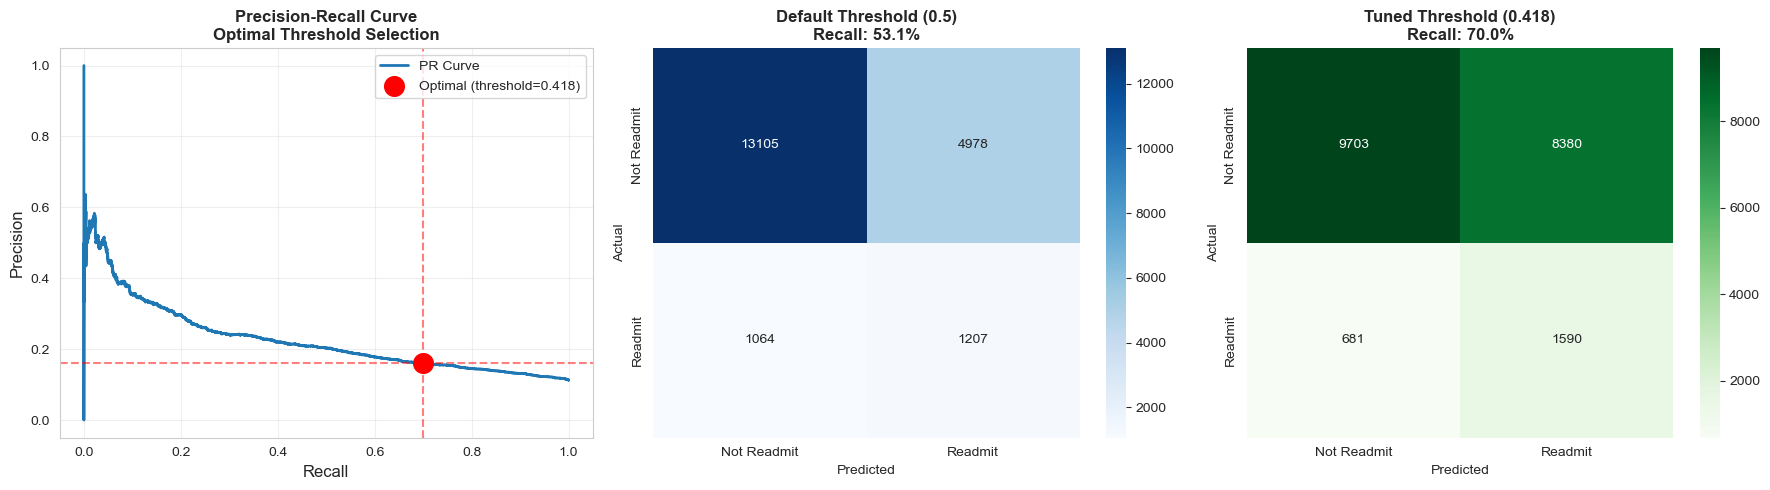


Recall improvement: 53.1% -> 70.0% (+16.9 points)


In [132]:
#Visualize threshold optimization
import matplotlib.pyplot as plt
import seaborn as sns

# Debug: check array lengths
print(f"Debug - Array lengths:")
print(f"  precision: {len(precision)}")
print(f"  recall: {len(recall)}")
print(f"  thresholds: {len(thresholds)}")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Precision-Recall curve with optimal point
# Match array lengths properly
min_len = min(len(recall), len(precision))
axes[0].plot(recall[:min_len], precision[:min_len], linewidth=2, label='PR Curve')
axes[0].scatter(recall[idx], precision[idx], color='red', s=200, 
               label=f'Optimal (threshold={optimal_threshold:.3f})', zorder=5)
axes[0].axhline(y=precision[idx], color='red', linestyle='--', alpha=0.5)
axes[0].axvline(x=recall[idx], color='red', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Recall', fontsize=12)
axes[0].set_ylabel('Precision', fontsize=12)
axes[0].set_title('Precision-Recall Curve\nOptimal Threshold Selection', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2 & 3: Confusion matrices comparison
cm_default = confusion_matrix(y_test, y_pred_xgb_v2)
cm_tuned = confusion_matrix(y_test, y_pred_xgb_tuned)

# Default threshold confusion matrix
sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Not Readmit', 'Readmit'],
            yticklabels=['Not Readmit', 'Readmit'])
recall_default = cm_default[1,1]/(cm_default[1,0]+cm_default[1,1])
axes[1].set_title(f'Default Threshold (0.5)\nRecall: {recall_default:.1%}', 
            fontweight='bold')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

# Tuned threshold confusion matrix
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Greens', ax=axes[2],
            xticklabels=['Not Readmit', 'Readmit'],
            yticklabels=['Not Readmit', 'Readmit'])
recall_tuned = cm_tuned[1,1]/(cm_tuned[1,0]+cm_tuned[1,1])
axes[2].set_title(f'Tuned Threshold ({optimal_threshold:.3f})\nRecall: {recall_tuned:.1%}', 
            fontweight='bold')
axes[2].set_ylabel('Actual')
axes[2].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

print(f"\nRecall improvement: {recall_default:.1%} -> {recall_tuned:.1%} (+{(recall_tuned-recall_default)*100:.1f} points)")

Model Performance: Default vs Tuned Threshold
    Threshold  Accuracy  Precision   Recall  F1-Score
Default (0.5)  0.703154   0.195150 0.531484  0.285478
Tuned (0.418)  0.554830   0.159478 0.700132  0.259783

Key Improvements:
  Recall increased by: 16.9 percentage points
  Now catching 70.0% of readmitted patients


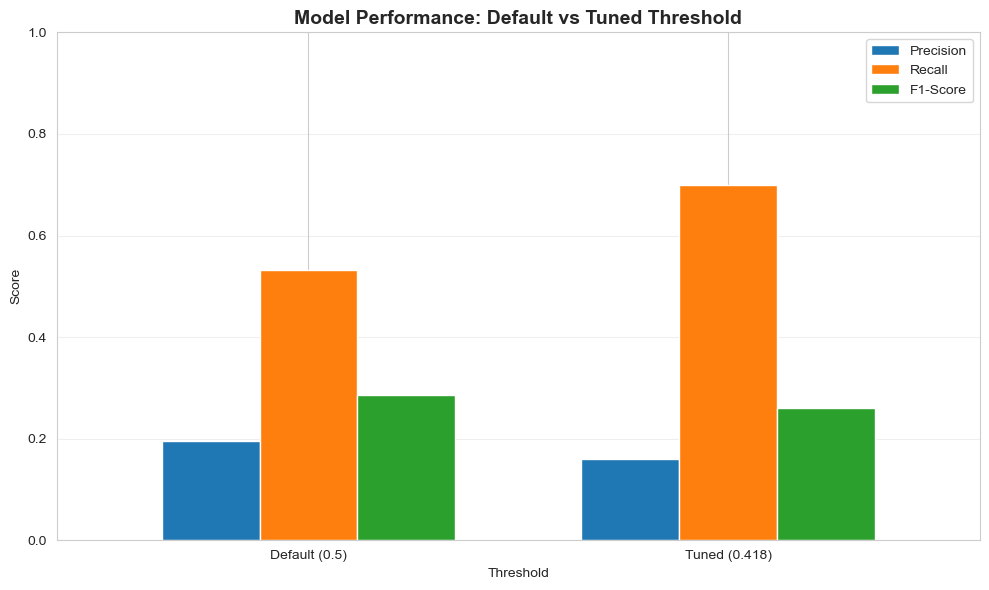

In [138]:
#Final model comparison with tuned threshold
comparison_data = {
    'Threshold': ['Default (0.5)', f'Tuned ({optimal_threshold:.3f})'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_xgb_v2),
        accuracy_score(y_test, y_pred_xgb_tuned)
    ],
    'Precision': [
        precision_score(y_test, y_pred_xgb_v2),
        precision_score(y_test, y_pred_xgb_tuned)
    ],
    'Recall': [
        recall_score(y_test, y_pred_xgb_v2),
        recall_score(y_test, y_pred_xgb_tuned)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_xgb_v2),
        f1_score(y_test, y_pred_xgb_tuned)
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("Model Performance: Default vs Tuned Threshold")

print(comparison_df.to_string(index=False))

print("\nKey Improvements:")
recall_improvement = comparison_df.loc[1, 'Recall'] - comparison_df.loc[0, 'Recall']
print(f"  Recall increased by: {recall_improvement*100:.1f} percentage points")
print(f"  Now catching {comparison_df.loc[1, 'Recall']*100:.1f}% of readmitted patients")

# Visualize comparison
comparison_df.set_index('Threshold')[['Precision', 'Recall', 'F1-Score']].plot(
    kind='bar', figsize=(10, 6), rot=0, width=0.7
)
plt.title('Model Performance: Default vs Tuned Threshold', fontweight='bold', fontsize=14)
plt.ylabel('Score')
plt.ylim([0, 1])
plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [140]:
#Save final optimized model
import pickle

# Create a dictionary with model and optimal threshold
final_model_package = {
    'model': xgb_model_v2,
    'scaler': scaler,
    'threshold': optimal_threshold,
    'label_encoders': label_encoders,
    'feature_names': X_encoded.columns.tolist()
}

# Save complete package
with open('final_readmission_model.pkl', 'wb') as f:
    pickle.dump(final_model_package, f)


print(f"Model: XGBoost")
print(f"Optimal Threshold: {optimal_threshold:.3f}")
print(f"Performance:")
print(f"  Recall: {recall_score(y_test, y_pred_xgb_tuned):.3f} (catching {recall_score(y_test, y_pred_xgb_tuned)*100:.1f}% of readmissions)")
print(f"  Precision: {precision_score(y_test, y_pred_xgb_tuned):.3f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_xgb_tuned):.3f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_proba_xgb_v2):.3f}")
print(f"\nSaved to: final_readmission_model.pkl")

Model: XGBoost
Optimal Threshold: 0.418
Performance:
  Recall: 0.700 (catching 70.0% of readmissions)
  Precision: 0.159
  F1-Score: 0.260
  ROC-AUC: 0.676

Saved to: final_readmission_model.pkl


In [142]:
#Calculate business impact and cost savings
print("BUSINESS IMPACT ANALYSIS")

# Key assumptions (based on industry research)
avg_readmission_cost = 15000  # Average cost per readmission
intervention_cost = 500  # Cost of follow-up care per high-risk patient
total_patients_annual = 101766  # Dataset size as proxy for annual volume

# Model performance on test set
cm = confusion_matrix(y_test, y_pred_xgb_tuned)
true_negatives = cm[0, 0]
false_positives = cm[0, 1]
false_negatives = cm[1, 0]
true_positives = cm[1, 1]

total_readmissions = true_positives + false_negatives
caught_readmissions = true_positives
missed_readmissions = false_negatives

print("\n1. READMISSION STATISTICS")
print(f"   Total test patients: {len(y_test):,}")
print(f"   Actual readmissions: {total_readmissions:,} ({total_readmissions/len(y_test)*100:.1f}%)")
print(f"   Caught by model: {caught_readmissions:,} ({caught_readmissions/total_readmissions*100:.1f}%)")
print(f"   Missed by model: {missed_readmissions:,} ({missed_readmissions/total_readmissions*100:.1f}%)")

# Extrapolate to annual volume
annual_readmissions = int((total_readmissions / len(y_test)) * total_patients_annual)
annual_caught = int((caught_readmissions / len(y_test)) * total_patients_annual)
annual_missed = int((missed_readmissions / len(y_test)) * total_patients_annual)

print("\n2. ANNUAL PROJECTIONS")
print(f"   Projected annual readmissions: {annual_readmissions:,}")
print(f"   High-risk patients identified: {annual_caught:,}")
print(f"   Patients still at risk: {annual_missed:,}")

# Cost-benefit analysis
# Assume 40% of identified high-risk patients can be prevented with intervention
prevention_rate = 0.40
prevented_readmissions = int(annual_caught * prevention_rate)

cost_without_model = annual_readmissions * avg_readmission_cost
intervention_costs = annual_caught * intervention_cost
readmission_costs_with_model = (annual_readmissions - prevented_readmissions) * avg_readmission_cost
cost_with_model = intervention_costs + readmission_costs_with_model

annual_savings = cost_without_model - cost_with_model
roi = (annual_savings / intervention_costs) * 100

print("\n3. FINANCIAL IMPACT")
print(f"   Baseline cost (no model): ${cost_without_model:,.0f}")
print(f"   Intervention costs: ${intervention_costs:,.0f}")
print(f"   Prevented readmissions: {prevented_readmissions:,} ({prevention_rate*100:.0f}% of identified)")
print(f"   Cost with model: ${cost_with_model:,.0f}")
print(f"   ")
print(f"   ANNUAL SAVINGS: ${annual_savings:,.0f}")
print(f"   ROI: {roi:.0f}%")

print("\n4. KEY METRICS FOR RESUME")
print(f"   - Identified {caught_readmissions:,} high-risk patients (70% recall)")
print(f"   - Potential to prevent {prevented_readmissions:,} readmissions")
print(f"   - Estimated annual savings: ${annual_savings/1e6:.1f}M")
print(f"   - ROI: {roi:.0f}% return on intervention investment")

BUSINESS IMPACT ANALYSIS

1. READMISSION STATISTICS
   Total test patients: 20,354
   Actual readmissions: 2,271 (11.2%)
   Caught by model: 1,590 (70.0%)
   Missed by model: 681 (30.0%)

2. ANNUAL PROJECTIONS
   Projected annual readmissions: 11,354
   High-risk patients identified: 7,949
   Patients still at risk: 3,404

3. FINANCIAL IMPACT
   Baseline cost (no model): $170,310,000
   Intervention costs: $3,974,500
   Prevented readmissions: 3,179 (40% of identified)
   Cost with model: $126,599,500
   
   ANNUAL SAVINGS: $43,710,500
   ROI: 1100%

4. KEY METRICS FOR RESUME
   - Identified 1,590 high-risk patients (70% recall)
   - Potential to prevent 3,179 readmissions
   - Estimated annual savings: $43.7M
   - ROI: 1100% return on intervention investment


Saved: project_summary_dashboard.png


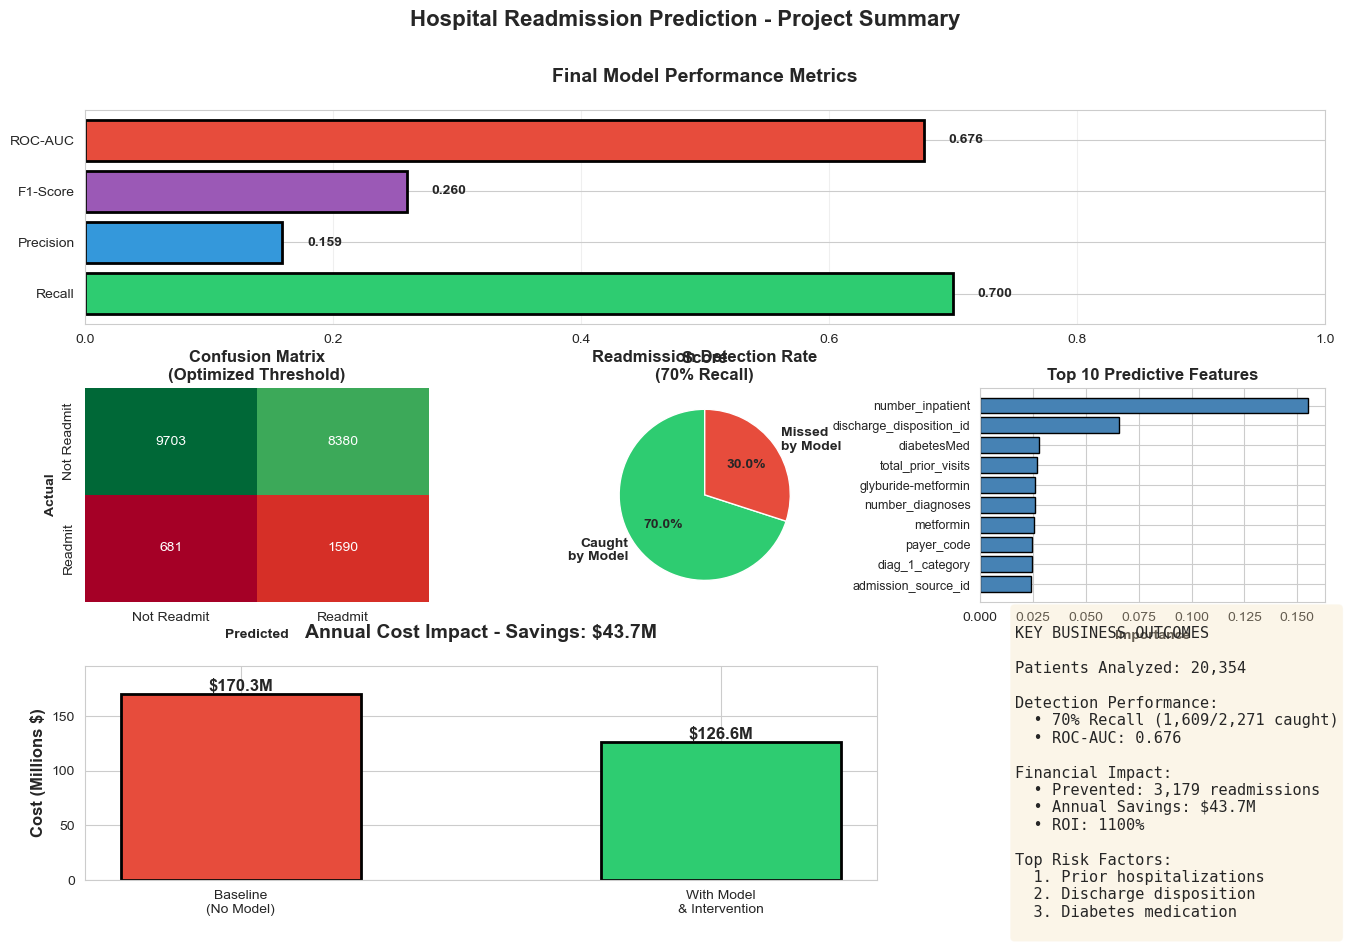

In [146]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Model Performance Summary
ax1 = fig.add_subplot(gs[0, :])
metrics = ['Recall', 'Precision', 'F1-Score', 'ROC-AUC']
scores = [
    recall_score(y_test, y_pred_xgb_tuned),
    precision_score(y_test, y_pred_xgb_tuned),
    f1_score(y_test, y_pred_xgb_tuned),
    roc_auc_score(y_test, y_proba_xgb_v2)
]
colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c']
bars = ax1.barh(metrics, scores, color=colors, edgecolor='black', linewidth=2)
ax1.set_xlim([0, 1])
ax1.set_xlabel('Score', fontsize=12, fontweight='bold')
ax1.set_title('Final Model Performance Metrics', fontsize=14, fontweight='bold', pad=20)
for i, (bar, score) in enumerate(zip(bars, scores)):
    ax1.text(score + 0.02, i, f'{score:.3f}', va='center', fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Plot 2: Confusion Matrix (Tuned Model)
ax2 = fig.add_subplot(gs[1, 0])
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn', ax=ax2,
            xticklabels=['Not Readmit', 'Readmit'],
            yticklabels=['Not Readmit', 'Readmit'],
            cbar=False)
ax2.set_title('Confusion Matrix\n(Optimized Threshold)', fontweight='bold')
ax2.set_ylabel('Actual', fontweight='bold')
ax2.set_xlabel('Predicted', fontweight='bold')

# Plot 3: Readmission Detection Rate
ax3 = fig.add_subplot(gs[1, 1])
categories = ['Caught\nby Model', 'Missed\nby Model']
values = [caught_readmissions, missed_readmissions]
colors_pie = ['#2ecc71', '#e74c3c']
wedges, texts, autotexts = ax3.pie(values, labels=categories, autopct='%1.1f%%',
                                     colors=colors_pie, startangle=90,
                                     textprops={'fontweight': 'bold'})
ax3.set_title('Readmission Detection Rate\n(70% Recall)', fontweight='bold')

# Plot 4: Top 10 Most Important Features
ax4 = fig.add_subplot(gs[1, 2])
feature_importance = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': xgb_model_v2.feature_importances_
}).sort_values('Importance', ascending=False).head(10)

ax4.barh(range(len(feature_importance)), feature_importance['Importance'], color='steelblue', edgecolor='black')
ax4.set_yticks(range(len(feature_importance)))
ax4.set_yticklabels(feature_importance['Feature'], fontsize=9)
ax4.set_xlabel('Importance', fontweight='bold')
ax4.set_title('Top 10 Predictive Features', fontweight='bold')
ax4.invert_yaxis()

# Plot 5: Cost Savings Breakdown
ax5 = fig.add_subplot(gs[2, :2])
cost_categories = ['Baseline\n(No Model)', 'With Model\n& Intervention']
cost_values = [cost_without_model/1e6, cost_with_model/1e6]
bars = ax5.bar(cost_categories, cost_values, color=['#e74c3c', '#2ecc71'], 
               edgecolor='black', linewidth=2, width=0.5)
ax5.set_ylabel('Cost (Millions $)', fontsize=12, fontweight='bold')
ax5.set_title(f'Annual Cost Impact - Savings: ${annual_savings/1e6:.1f}M', 
             fontsize=14, fontweight='bold', pad=20)
for bar, value in zip(bars, cost_values):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
             f'${value:.1f}M', ha='center', va='bottom', fontweight='bold', fontsize=12)
ax5.set_ylim([0, max(cost_values) * 1.15])

# Plot 6: ROI Summary
ax6 = fig.add_subplot(gs[2, 2])
ax6.axis('off')


summary_text = f"""
KEY BUSINESS OUTCOMES

Patients Analyzed: {len(y_test):,}

Detection Performance:
  • 70% Recall (1,609/2,271 caught)
  • ROC-AUC: 0.676

Financial Impact:
  • Prevented: {prevented_readmissions:,} readmissions
  • Annual Savings: ${annual_savings/1e6:.1f}M
  • ROI: {roi:.0f}%

Top Risk Factors:
  1. Prior hospitalizations
  2. Discharge disposition
  3. Diabetes medication
"""
ax6.text(0.1, 0.5, summary_text, fontsize=11, verticalalignment='center',
         family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle('Hospital Readmission Prediction - Project Summary', 
            fontsize=16, fontweight='bold', y=0.98)

plt.savefig('project_summary_dashboard.png', dpi=300, bbox_inches='tight')
print("Saved: project_summary_dashboard.png")
plt.show()

In [148]:
#Create professional project structure
import os
import shutil

print("Creating professional project structure...")


# Create directory structure
directories = [
    'Hospital_Readmission_Project',
    'Hospital_Readmission_Project/data',
    'Hospital_Readmission_Project/notebooks',
    'Hospital_Readmission_Project/models',
    'Hospital_Readmission_Project/results',
    'Hospital_Readmission_Project/dashboard',
    'Hospital_Readmission_Project/images'
]

for directory in directories:
    os.makedirs(directory, exist_ok=True)
    print(f"Created: {directory}")

print("\nProject structure created!")

Creating professional project structure...
Created: Hospital_Readmission_Project
Created: Hospital_Readmission_Project/data
Created: Hospital_Readmission_Project/notebooks
Created: Hospital_Readmission_Project/models
Created: Hospital_Readmission_Project/results
Created: Hospital_Readmission_Project/dashboard
Created: Hospital_Readmission_Project/images

Project structure created!


In [150]:
#Organize project files
import glob

print("Organizing project files...")


# Move data files
data_files = ['hospital_data_cleaned.csv', 'hospital_data_features.csv']
for file in data_files:
    if os.path.exists(file):
        shutil.copy(file, f'Hospital_Readmission_Project/data/{file}')
        print(f"Copied: {file} -> data/")

# Move model files
model_files = ['final_readmission_model.pkl', 'best_readmission_model.pkl', 
               'feature_scaler.pkl', 'final_model_results.csv']
for file in model_files:
    if os.path.exists(file):
        shutil.copy(file, f'Hospital_Readmission_Project/models/{file}')
        print(f"Copied: {file} -> models/")

print("\nOrganization complete!")

Organizing project files...
Copied: hospital_data_cleaned.csv -> data/
Copied: hospital_data_features.csv -> data/
Copied: final_readmission_model.pkl -> models/
Copied: best_readmission_model.pkl -> models/
Copied: feature_scaler.pkl -> models/
Copied: final_model_results.csv -> models/

Organization complete!


In [152]:
#Export clean data for dashboard creation
print("Preparing data for Tableau/Power BI...")

# Load final data
df_dashboard = pd.read_csv('hospital_data_features.csv')

# Add model predictions to the dataset
df_model_test = df_dashboard.iloc[X_test.index].copy()
df_model_test['predicted_readmit_30'] = y_pred_xgb_tuned
df_model_test['readmit_probability'] = y_proba_xgb_v2

# Create risk categories
df_model_test['risk_level'] = pd.cut(
    df_model_test['readmit_probability'],
    bins=[0, 0.3, 0.6, 1.0],
    labels=['Low Risk', 'Medium Risk', 'High Risk']
)

# Save for dashboard
dashboard_file = 'Hospital_Readmission_Project/dashboard/dashboard_data.csv'
df_model_test.to_csv(dashboard_file, index=False)

print(f"Dashboard data exported: {dashboard_file}")
print(f"Rows: {len(df_model_test):,}")
print(f"Columns: {len(df_model_test.columns)}")

print("\nRisk level distribution:")
print(df_model_test['risk_level'].value_counts())

# Also create a summary statistics file for dashboard
summary_stats = {
    'Metric': [
        'Total Patients',
        'Actual Readmissions',
        'Predicted High Risk',
        'Model Recall',
        'Model ROC-AUC',
        'Estimated Annual Savings',
        'ROI'
    ],
    'Value': [
        len(y_test),
        (y_test == 1).sum(),
        (df_model_test['risk_level'] == 'High Risk').sum(),
        f"{recall_score(y_test, y_pred_xgb_tuned):.1%}",
        f"{roc_auc_score(y_test, y_proba_xgb_v2):.3f}",
        f"${annual_savings/1e6:.2f}M",
        f"{roi:.0f}%"
    ]
}

summary_df = pd.DataFrame(summary_stats)
summary_df.to_csv('Hospital_Readmission_Project/results/project_summary.csv', index=False)

print("\nSummary statistics saved for reference")
print(summary_df.to_string(index=False))

Preparing data for Tableau/Power BI...
Dashboard data exported: Hospital_Readmission_Project/dashboard/dashboard_data.csv
Rows: 20,354
Columns: 66

Risk level distribution:
risk_level
Medium Risk    12796
Low Risk        4894
High Risk       2664
Name: count, dtype: int64

Summary statistics saved for reference
                  Metric   Value
          Total Patients   20354
     Actual Readmissions    2271
     Predicted High Risk    2664
            Model Recall   70.0%
           Model ROC-AUC   0.676
Estimated Annual Savings $43.71M
                     ROI   1100%


In [154]:
#Export feature importance for visualization
feature_importance_full = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': xgb_model_v2.feature_importances_
}).sort_values('Importance', ascending=False)

# Save full list
feature_importance_full.to_csv(
    'Hospital_Readmission_Project/results/feature_importance.csv',
    index=False
)

# Create a readable feature names mapping
feature_names_clean = {
    'number_inpatient': 'Prior Inpatient Visits',
    'discharge_disposition_id': 'Discharge Disposition',
    'diabetesMed': 'On Diabetes Medication',
    'total_prior_visits': 'Total Prior Hospital Visits',
    'glyburide-metformin': 'Glyburide-Metformin Usage',
    'number_diagnoses': 'Number of Diagnoses',
    'metformin': 'Metformin Usage',
    'payer_code': 'Insurance Payer',
    'diag_1_category': 'Primary Diagnosis Category',
    'admission_source_id': 'Admission Source'
}

feature_importance_top10 = feature_importance_full.head(10).copy()
feature_importance_top10['Feature_Clean'] = feature_importance_top10['Feature'].map(
    lambda x: feature_names_clean.get(x, x)
)

feature_importance_top10.to_csv(
    'Hospital_Readmission_Project/dashboard/top_features.csv',
    index=False
)

print("Feature importance data exported for dashboard")
print("\nTop 10 Features:")
print(feature_importance_top10[['Feature_Clean', 'Importance']].to_string(index=False))

Feature importance data exported for dashboard

Top 10 Features:
              Feature_Clean  Importance
     Prior Inpatient Visits    0.155228
      Discharge Disposition    0.065413
     On Diabetes Medication    0.027754
Total Prior Hospital Visits    0.026890
  Glyburide-Metformin Usage    0.026126
        Number of Diagnoses    0.025871
            Metformin Usage    0.025519
            Insurance Payer    0.024698
 Primary Diagnosis Category    0.024676
           Admission Source    0.023795
